# Plotly

---
**Overview.**  We introduce and apply a new and exciting graphics package [plotly](https://plot.ly/python/).  We show how we can leverage our knowledge of Matplotlib to jumpstart our usage of plotly. We then show how to access some of [plotly's unique features](https://plot.ly/python/) to do things that are difficult or impossible with our knowledge of matplotilb.

**Outline**

- [Loading data](#data): `pd.read_html` example to get latitude and longitude coordinates for country capitals
- [Matplotlylib](#matplotlylib): converting a matplotlib figure to a plotly figure
- [Plotly api](#api): covers the basics of plotly's own api
- [Maps](#maps): building maps with plotly


**Note: requires internet access to run.**  

This IPython notebook was created by Dave Backus, Chase Coleman, and Spencer Lyon for the NYU Stern course [Data Bootcamp](http://databootcamp.nyuecon.com/).  

---

## Reminders

* Packages.  Collections of tools that extend Python's capabilities. We add them with `import` statements.  
* `conda` and `pip`: package managers for python. Install new packages using `conda install package_name` or `pip3 install package name`.

We will need to have the plotly python package installed. To do this enter the
following from the command line (command prompt on windows, terminal on mac):

```
pip install plotly
pip install cufflinks
```

Once you've done that, come back to this notebook and run the following cell to
make sure plotly is installed properly.

In [46]:
import sys                             # system module
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for Pandas
import seaborn.apionly as sns          # fancy matplotlib graphics (no styling)
from pandas.io import data, wb         # worldbank data

# plotly imports
from plotly.offline import iplot, iplot_mpl  # plotting functions
import plotly.graph_objs as go               # ditto
import plotly                                # just to print version and init notebook
import cufflinks as cf                       # gives us df.iplot that feels like df.plot
cf.set_config_file(offline=True, offline_show_link=False)

# these lines make our graphics show up in the notebook
%matplotlib inline             
plotly.offline.init_notebook_mode()

# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Plotly version: ', plotly.__version__)
print('Today: ', dt.date.today())

Python version: 3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.18.0
Plotly version:  1.9.7
Today:  2016-04-27


## Data Sources <a id=data></a>

Before we get too far, we'll need some data. Let's get some now.

First we will download precipitation data from the World Bank for all countries in Europe. In order to put this data on a map we will need to have either the 3 letter ISO code for the country or latitude and longitude coordinates. We'll grab both here. This will be a little sophistocated, so bear with us. 

We show these steps here so that you can re-use this code if you want to do something similar in the future.

In [47]:
# read a list of latitude and longitude coordinates for
# country capitals
lat_lon = pd.read_html("http://www.csgnetwork.com/llinfotable.html", header=0, 
                       attrs={"align": "center", "cellpadding": 5, "bgcolor": "#FFFFFF"})[0]

# clean up so lat and long are numeric in degrees east and degrees north
def clean_latlon(series, to_negate):
    # get XX.YY data
    split1 = series.str.split("°")
    split2 = split1.str.get(1).str.split("'")
    data = split1.str.get(0) + "." + split1.str.get(0)
    
    # now add a negative side if last character == to_negate
    signs = split2.str.get(1) == to_negate
    signs = signs.replace({True: "-", False: ""})
    
    data = signs.str[:] + data.str[:]
    return data.astype(float)
    
lat_lon["Latitude"] = clean_latlon(lat_lon["Latitude"], "S")
lat_lon["Longitude"] = clean_latlon(lat_lon["Longitude"], "W")
lat_lon = lat_lon.drop("Capital", axis=1)
lat_lon = lat_lon.set_index("Country")
lat_lon.head()

,Latitude,Longitude
Country,,
Afghanistan,34.34,69.69
Albania,41.41,19.19
Algeria,36.36,3.03
American Samoa,-14.14,-170.17
Andorra,42.42,1.01


In [48]:
# dataframe of country names and iso codes
url = "http://unstats.un.org/unsd/methods/m49/m49alpha.htm"
iso = pd.read_html(url, attrs={"border": "0", "cellpadding": "2"}, header=0)[0]
iso = iso.rename(columns={"ISO ALPHA-3 code": "ISO", 
                          "Country or area name": "Country"})
iso = iso.drop("Numerical  code", axis=1)
iso = iso.set_index("Country")
iso.head()

,ISO
Country,
Afghanistan,AFG
Åland Islands,ALA
Albania,ALB
Algeria,DZA
American Samoa,ASM


In [27]:
# get data from worldbank
europe = ["Albania",  "Andorra",  "Armenia",  "Austria",  "Azerbaijan",  "Belarus",
          "Belgium",  "Bosnia and Herzegovina",  "Bulgaria",  "Croatia",  "Cyprus",
          "Czech Republic",  "Denmark",  "Estonia",  "Finland",  "France",  "Georgia",
          "Germany",  "Greece",  "Hungary",  "Iceland",  "Ireland",  "Italy",
          "Kazakhstan",  "Kosovo",  "Latvia",  "Liechtenstein",  "Lithuania",
          "Luxembourg",  "Macedonia",  "Malta",  "Moldova",  "Monaco",  "Montenegro",
          "Netherlands",  "Norway",  "Poland",  "Portugal",  "Romania",  "Russia",  
          "San Marino",  "Serbia",  "Slovakia",  "Slovenia",  "Spain",  "Sweden",
          "Switzerland",  "Turkey",  "Ukraine",  "United Kingdom",  "Vatican City"]

iso_europe = iso[iso.index.isin(europe)]
rain = wb.download(country=iso_europe["ISO"], indicator=["AG.LND.PRCP.MM"], 
                   start=2014, end=2014)
rain = rain.reset_index(level="year", drop=True)
rain.index.name = "Country"

# some countries didn't have data. Drop them now
rain = rain.dropna()
rain.columns = ["Precipitation"]
rain.head()

,Precipitation
Country,
Albania,1485.0
Armenia,562.0
Austria,1110.0
Azerbaijan,447.0
Belgium,847.0


In [28]:
# now we will merge in iso codes and latitidue/longitude data
rain = rain.merge(iso, left_index=True, right_index=True)
rain = rain.merge(lat_lon, left_index=True, right_index=True)
rain.head()

,Precipitation,ISO,Latitude,Longitude
Country,,,,
Albania,1485.0,ALB,41.41,19.19
Armenia,562.0,ARM,40.40,44.44
Austria,1110.0,AUT,48.48,16.16
Azerbaijan,447.0,AZE,40.40,49.49
Belarus,618.0,BLR,53.53,27.27


In [49]:
# Earnings by school and gender. Source plotly docs. Real source, unknown
url = "https://raw.githubusercontent.com/plotly/datasets/master/school_earnings.csv"
earnings = pd.read_csv(url)
print(earnings.head())

earnings = earnings.set_index("School")
earnings = earnings.sort_values("Men")
print("\n\nAfter set_index and sort_values:\n")
print(earnings.head())

      School  Women  Men  gap
0        MIT     94  152   58
1   Stanford     96  151   55
2    Harvard    112  165   53
3     U.Penn     92  141   49
4  Princeton     90  137   47


After set_index and sort_values:

          Women  Men  gap
School                   
UCLA         64   78   14
SoCal        72   81    9
Emory        68   82   14
Michigan     62   84   22
Berkeley     71   88   17


In [50]:
# tips at restaurants in NYC. Source unknown, but classic dataset
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [51]:
# Data on flowers. Source unknown. Classic data set
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [52]:
# info on titanic passengers. Source unknown.
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Background

Plotly is a javascript based plotting library. Plotly leverages industry grade
javascript technologies to provide great flexibility and good performance.
Being a javascript library, plotly graphics are inherently interactive meant to be 
viewed in a webbrowser. The good news is that we can embed our interactive 
plots in any website: Jupyter notebooks, blog posts, etc. The *great* news is 
that we don't have to write any javascript ourselves!

The plotly project was started about four years ago. Over that time, plotly has
transitioned between three phases:

1. Online only mode: plotly started as a web service where you uploaded your
data and constructed plots on their website.
2. Online plotting mode: the next phase was to allow you to build plots from
your favorite programming language (Python!), but the plots were actually
created on their servers and you were given a link to view the plot on their
website.
3. Offline mode: You can now construct plotly graphics 100% offline. While all
three modes still exist, we will use the purely offline mode in our notes.

## Matplotlylib <a id=matplotlylib></a>

As a warmup, let's utilize our expertise of Matplotlib to quickly generate some basic plotly graphics. 

The main steps in this process are:

1. Construct a matplotlib figure as we normally do.
2. Pass the `Figure` object (usually named `fig` in our examples) to the function `iplot_mpl`.

That's it!

**Disclaimer**: the functions that convert matplotlib figures to plotly figures are not perfect. We'll see some issues below, but will show how to build the plots using plotly's API so they look as we expect.


We'll start by looking at some examples from the seaborn documentation. The actual figures are not important here. We are mostly concerned with how well matplotlylib can take a matplotlib figure and construct a plotly figure.

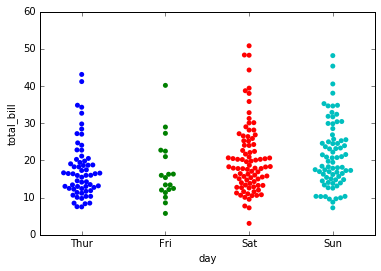

In [53]:
ax = sns.swarmplot(x="day", y="total_bill", data=tips)
fig_mpl = ax.get_figure()

Now let's convert our Matplotlib figure `fig_mpl` into a plotly figure named `fig_py`. To do this we will use the function `iplot_mpl` as follows:

In [54]:
iplot_mpl(fig_mpl)

For this example we see that the converter did a decent job, though it didn't quite get the xlabels correct

Let's try another example

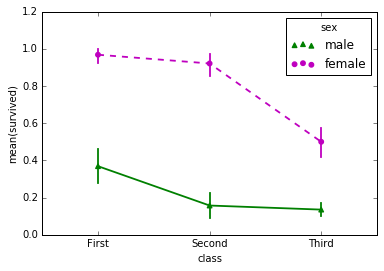

In [55]:
out = sns.pointplot(x="class", y="survived", hue="sex", data=titanic,
                    palette={"male": "g", "female": "m"},
                    markers=["^", "o"], linestyles=["-", "--"]);

In [56]:
iplot_mpl(out.get_figure())

C:\Users\dbackus\AppData\Local\Continuum\Anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:445: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

C:\Users\dbackus\AppData\Local\Continuum\Anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:481: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



What worked well in this conversion? What didn't work?

Let's do one more example using the college graduate data

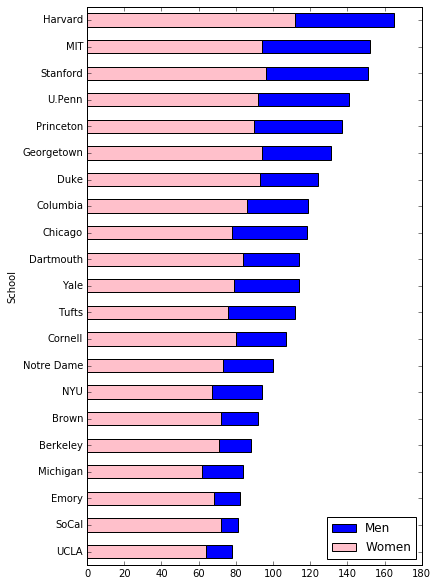

In [57]:
fig_mpl, ax = plt.subplots(figsize=(6, 10))
earnings.plot.barh(ax=ax, y="Men", color="Blue")
earnings.plot.barh(ax=ax, y="Women", color="Pink");

In [61]:
foo = iplot_mpl(fig_mpl)

C:\Users\dbackus\AppData\Local\Continuum\Anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:516: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.

C:\Users\dbackus\AppData\Local\Continuum\Anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:481: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



What did and didn't work here?

Below we'll recreate this same figure using plotly's api and overcome these issues

## Plotly API <a id=api></a>

Let's now consider how to use plotly's own API to construct plots instead of
building the graphics through matplotlib. 

Plotly has over 20 core chart types and many more can be created by combining one or more chart types in the same figure. We don't have time to cover all of them here, but please check out the [documentation](https://plot.ly/python/).

Plotly has a purely **declarative** API. This means that we describe all the
features we want in our figure at once, without worrying about which functions
to call in what order.

The plotly can achieve this is by fully describing the plot in a data format called JSON. 
For our purposes we can think of JSON as dictionaries, where values can be of any type, 
including other dictionaries.

Plotly figures are composed of two things:

1. A list of **trace**s that describe the data that will be plotted and how it should appear
2. A **layout** that describes features of the overall plot. Things like ticks, labels, titles, fonts, margins, etc.

The `trace`s describe the data that should be plotted as well as how it should be displayed. Here's an example of a trace defining a scatter plot:

```python
trace = dict(type="scatter",  # trace type
             x=[1, 2, 3],     # x data
             y=[1, 4, 9],     # y data
             name="Squares"   # legend label
             )
```

In this example, `x`, `y`, `name` and `marker` are called the **attributes** of the trace. All traces have a `type` attribute that describes the type of chart to generate for a particular piece of data. Here we chose `scatter`, which is what plotly calls scatter plots or line plots.

An example of a `layout` is

```python
l = dict(title="Penguins food",            # plot title
         yaxis=dict(title="Quantity (%)",  # yaxis label
                    range=(0, 1)           # set limits for y axis
         )
```

Notice that the value associated with `yaxis` had type `dict`. This allowed us to control features of the yaxis.

For an overwhelmingly comprehensive overview of all trace types and their associated attributes (everything plotly can do) see the chart attribute [reference](https://plot.ly/python/reference/) in the plotly python documentation

After we have defined one or more traces and a layout, we build the plotly figure using the function `plotly.graph_objs.Figure`. The imports up top allow us to refer to this function as `go.Figure`. This is how we call the function:

```python
fig = go.Figure(data=D, layout=L)
```

where `D` is a list of **traces** and `L` describes the **layout**.

Finally, the last thing we need to know how to do is display the figure. In the notebook we will use the function `plotly.offline.iplot`, which we imported directly as `iplot`. To display the figure above we would do

```python
iplot(fig)
```

To get a feel for what this looks like, let's revisit the horizontal bar chart using the college grad earnings data.

Here's how we might build that figure using plotly's API

In [63]:
# the long way. Construct all the dicts by hand
men = dict(type="bar",                                      # trace type
           orientation="h",                                 # make bars horizontal
           name="Men",                                      # legend entry
           x=earnings["Men"],                               # x data
           y=earnings.index,                                # y data
           marker={"color": "Blue"}                         # blue bars
          )
women = dict(type="bar",                                    # trace type
             orientation="h",                               # horizontal bars
             name="Women",                                  # legend entry
             x=earnings["Women"],                           # x data
             y=earnings.index,                              # y data
             marker={"color": "Pink"}                       # pink bars
            )
layout = dict(width=650, height=750,                        # plot width/height
              yaxis={"title": "School"},                    # yaxis label
              title="Gender earnings disparity",            # title
              xaxis={"title": "Annual Salary (thousands)"}  # xaxis label}
             )
iplot(go.Figure(data=[men, women], layout=layout))

**Exercise**: now generate a similar plot using the `df.iplot` method. (*Hint* you can reuse the `layout` object from above)

In [76]:
earnings.iplot(layout=layout, kind="barh")

**Example: Dumbell plot**. The striking fact in the data is that there is a gap between earnings of men and women. To highlight that, here's another way we might visualize the same data:

In [78]:
men2 = dict(type="scatter", 
            name="Men", 
            mode="markers",                       # draw dots
            x=earnings["Men"],                    # x data
            y=earnings.index,                     # y data
            marker={"color": "Blue", "size": 12}  # dot color/size
           )
women2 = dict(type="scatter", name="Women", mode="markers",
              x=earnings["Women"], y=earnings.index,
              marker={"color": "Pink", "size": 12})

def draw_line(row):
    sc = row.name
    line = dict(type="scatter",                # trace type
                x=[row["Women"], row["Men"]],  # x data
                y=[sc, sc],                    # y data flat
                mode="lines",                  # draw line
                name=sc,                       # name trace
                showlegend=False,              # no legend entry
                line={"color": "gray"}         # line color
               )
    return line
lines = list(earnings.apply(draw_line, axis=1))

# use + for two lists
data = [men2, women2] + lines  

# build and display the figure
fig = go.Figure(data=data, layout=layout)
iplot(fig)

**Exercise**: Look at the [figure attribute reference](https://plot.ly/python/reference/) and figure out how to remove the grid lines from the figure above. First remove the veritcal ones, then horizontal, then both. (*Hint:* Look for an attribute on the `xaxis` and `yaxis` of the layout) (*Hint 2* you can get the layout by doing `fig.layout`)

## Maps <a id=maps></a>

We will finish this notebook by looking at some new things we can now do because we are using plotly. 

There are two map-based traces in plotly:

- `scattergeo`: this allows you do draw lines or dots on a map
- `choropleth`: this allows you to fill regions with different colors

There is also the `geo` layout attribute. We'll look

#### `scattergeo` dots

We'll look at the `scattergeo` trace type first. Suppose we want to draw dots on the map. There are two possible sets of trace attributes we can work with:

1. Set `lat` and `lon` each to a list that specifiy the latitide and longitude for each point repsectively
2. Set the `locationmode` to be one of `"ISO-3"`, `"USA-states"`, or `"country names"` and then set `location` to be a valid member of that mode.

We can then set any other attributes 

Let's see an example of each version:

In [41]:
# first create marker/layout objects we can re-use in both plots
marker = {"color": rain["Precipitation"],
          "size": rain["Precipitation"]/100,
          "colorscale": "Reds",
          "colorbar": {"title": "Precipitation mm"}}

layout = dict(geo={"scope": "europe", "resolution": 50}, 
              width=750, height=550)

In [42]:
# using location mode
trace = dict(type="scattergeo",      # trace type
             mode="markers",         # draw points
             locations=rain["ISO"],  # use ISO code
             marker=marker           # marker settings (size, color, ...)
            )

iplot(go.Figure(data=[trace], layout=layout), link_text="")

In [79]:
# using lat/lon mode
trace = dict(type="scattergeo",     # trace type
             mode="markers",        # draw dots
             lat=rain["Latitude"],  # latitude coordinate
             lon=rain["Longitude"], # longitude coordinate
             marker=marker          # marker settings (color, size...)
            )

iplot(go.Figure(data=[trace], layout=layout), link_text="")

#### `scattergeo` lines

Now supppose we want to draw lines from the Italy to France, Germany, and Spain.

We can do this using `scattergeo` traces, where the lat and lon attributes on each trace are of length 2. The point will be drawn from `(lat[0], lon[0])` to `(lat[1], lon[1])`:

In [81]:
def get_lat_lon_for(df, iso):
    lat = df["Latitude"][df["ISO"] == iso]
    lon = df["Longitude"][df["ISO"] == iso]
    return float(lat), float(lon)

i_lat, i_lon = get_lat_lon_for(rain, "ITA")
traces = []

for country in ["FRA", "ESP", "DEU"]:
    lat, lon = get_lat_lon_for(rain, country)
    trace = dict(type="scattergeo",                # trace type
                 mode="lines",                     # draw lines
                 lat=[i_lat, lat],                 # latitude coordinates
                 lon=[i_lon, lon],                 # longitude coordinates
                 line={"width": 4.0},              # thick lines
                 name="ITA to {}".format(country)  # legend entry
                )
    traces.append(trace)

iplot(go.Figure(data=traces, layout=layout))

### Choropleth

The other type of map plotly can create is called a choropleth map. Here we have each region filled in with a solid color.

Let's use our country data to see what this looks like

In [82]:
trace = dict(type="choropleth",
             locations=rain["ISO"],   # use ISO names
             z=rain["Precipitation"], # defines the color
             colorscale="Viridis",    # change pallette
             text=rain.index,         # change text on hover
             )

# reuse the same layout
iplot(go.Figure(data=[trace], layout=layout), link_text="")